Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tqdm as tqdm

Solving Classical LK 2D system

In [2]:
# Define the Lotka-Volterra system
def LV(x, a, b, c, d):    
    xdot = np.array([a*x[0] - b*x[0]*x[1], d*x[0]*x[1] - c*x[1]])
    return xdot

In [3]:
def RK4(f, x0, t0, tf, num_points):
    
    t = np.linspace(t0,tf, num_points)
    dt = (tf - t0) / (num_points - 1)
    nt = t.size
    
    nx = x0.size
    x = np.zeros((nx,nt))
    
    x[:,0] = x0
    
    for k in range(nt-1):
        k1 = dt*f(t[k], x[:,k])
        k2 = dt*f(t[k] + dt/2, x[:,k] + k1/2)
        k3 = dt*f(t[k] + dt/2, x[:,k] + k2/2)
        k4 = dt*f(t[k] + dt, x[:,k] + k3)
        
        dx=(k1 + 2*k2 + 2*k3 +k4)/6
        x[:,k+1] = x[:,k] + dx;  
    
    return x, t

In [4]:
# Defining the problem
a = 1
b = 1
c = 1
d = 1

f= lambda t,x : np.array([a*x[0] - b*x[0]*x[1], d*x[0]*x[1] - c*x[1]])         # lambda is an anonymous function which can take may inputs but returns one output. Same case is with MATLAB denoted by @.
x0 = np.array([0.5,1])                 # initial condition    

# Solving the problem
t0 = 0                                # time unit is second
tf = 15
num_points = 1000
x, t = RK4(f, x0, t0, tf, num_points)

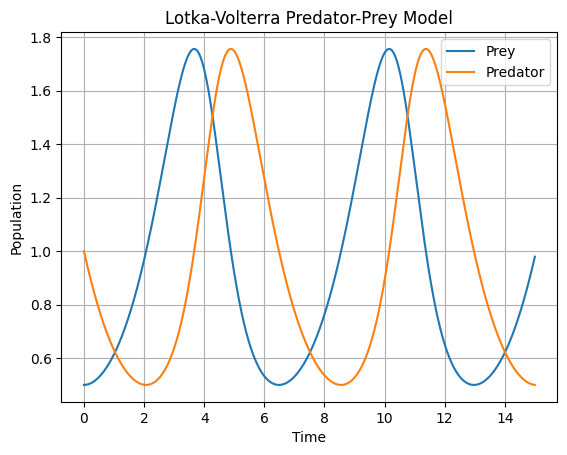

In [5]:
# Plot the solution
plt.plot(t, x[0,:], label='Prey')
plt.plot(t, x[1,:], label='Predator')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Lotka-Volterra Predator-Prey Model')
plt.legend()
plt.grid(True)
plt.show()

Generating Observational Data 

In [18]:
# Generate 8 equispaced time locations in the domain for fair comparison with ABC-SMC
obs_ind = np.linspace(0, len(t) - 1, 8, dtype=int)

# Get solution at those time locations
x_obs = np.array([x[0][ind] for ind in obs_ind])
y_obs = np.array([x[1][ind] for ind in obs_ind])

# Generate Gaussian noise to add to the observations
noise_x = 0.01 * x_obs * np.random.randn(len(x_obs))
noise_y = 0.01 * x_obs * np.random.randn(len(y_obs))

# Add the noise to the observed values
x_obs_noise = [x_obs[ind] + noise_x[ind] for ind in range(len(x_obs))]
y_obs_noise = [y_obs[ind] + noise_y[ind] for ind in range(len(y_obs))]

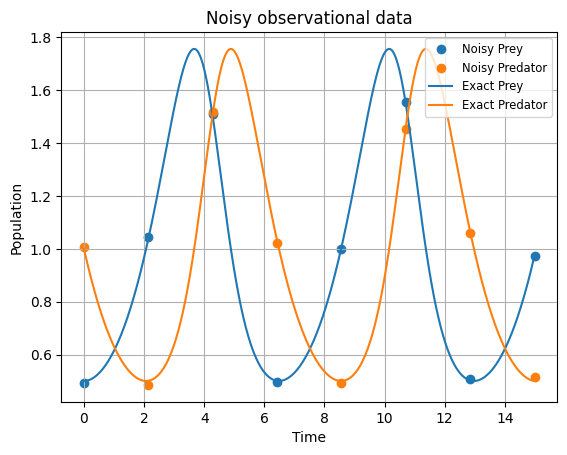

In [19]:
plt.figure()
plt.title("Noisy observational data")
plt.scatter([t[ind] for ind in obs_ind], x_obs_noise, label='Noisy Prey')
plt.scatter([t[ind] for ind in obs_ind], y_obs_noise, label='Noisy Predator')
plt.plot(t, x[0], label='Exact Prey')
plt.plot(t, x[1], label='Exact Predator')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.show()

Tensors

In [ ]:
# Tensor containing time locations for observations
t_obs = torch.tensor([t[ind] for ind in obs_ind], dtype=torch.float32).view(-1,1)
# Tensor with noisy observations for prey
u_obs_x = torch.tensor(x_obs_noise,  dtype=torch.float32).view(-1,1)
# Tensor with noisy observations for predator
u_obs_y = torch.tensor(y_obs_noise,  dtype=torch.float32).view(-1,1)
# Tensor of times to train PINN through physics loss
t_physics = torch.linspace(t0, tf, 500).view(-1, 1).requires_grad_(True)
# Tensor of times to check progress of PINN when training
t_test = torch.linspace(t0, tf, 200).view(-1, 1).requires_grad_(True)

Defining the Network

In [ ]:
class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch with sinusoidal activation"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce_predator = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.fce_prey = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        prey_output = self.fce_prey(x)
        predator_output = self.fce_predator(x)
        return prey_output, predator_output

Training the PINN to learn a parameter

In [ ]:
# Define PINN
pinn = FCN(1,1,32,3)

# Sample initial problems parameters from uniform 0 to 10 for comparison to be fair
a = torch.nn.Parameter(torch.empty(1).uniform_(0, 10), requires_grad=True)
b = torch.nn.Parameter(torch.empty(1).uniform_(0, 10), requires_grad=True)
c = torch.nn.Parameter(torch.empty(1).uniform_(0, 10), requires_grad=True)
d = torch.nn.Parameter(torch.empty(1).uniform_(0, 10), requires_grad=True)

a_s, b_s, c_s, d_s = [], [], [], []

# Define optimiser and make parameters learnable
optimiser = torch.optim.Adam(list(pinn.parameters())+[a,b,c,d],lr=1e-3)

# Hyperparameter deciding weight given to fitting observational data
lambda_weight = 100

# Initialize lists to store loss values
physics_loss_values = []
data_loss_values = []
total_loss_values = []

num_its = 30000

for i in tqdm.tqdm(range(num_its)):
    # Reset gradient to zero
    optimiser.zero_grad()

    # -----------------------
    #       PHYSICS LOSS
    # -----------------------
    u1,u2 = pinn(t_physics)

    # Compute the derivatives with respect to time
    du1dt = torch.autograd.grad(u1, t_physics, torch.ones_like(u1), create_graph=True)[0]
    du2dt = torch.autograd.grad(u2, t_physics, torch.ones_like(u2), create_graph=True)[0]

    # Compute the physics loss for Lotka-Volterra equations
    phy_loss_x = torch.mean((du1dt - a*u1 + b*u1*u2) ** 2)
    phy_loss_y = torch.mean((du2dt + c*u2 - d*u1*u2) ** 2)
    # Compute total physics loss
    total_physics_loss = phy_loss_x + phy_loss_y

    # -----------------------
    #       DATA LOSS
    # -----------------------
    # Compute the PINN output
    u1, u2 = pinn(t_obs)
    # Compute the data loss for the first equation (x)
    data_loss_x = torch.mean((u1 - u_obs_x)**2)
    # Compute the data loss for the second equation (y)
    data_loss_y = torch.mean((u2 - u_obs_y)**2)
    # Compute total data loss
    total_data_loss = data_loss_x + data_loss_y

    # Compute total loss
    loss = total_physics_loss + lambda_weight*total_data_loss

    # Backpropagate joint loss, take optimiser step
    loss.backward()
    optimiser.step()

    # Append loss values to lists
    physics_loss_values.append(total_physics_loss.item())
    data_loss_values.append(total_data_loss.item())
    total_loss_values.append(loss.item())

    # Keep track of parameter values
    a_s.append(a.item())
    b_s.append(b.item())
    c_s.append(c.item())
    d_s.append(d.item())

    # plot the result as training progresses
    if i % 2500 == 0: 
        u1, u2 = pinn(t_test)
        with torch.no_grad():
            plt.scatter(t_obs, u_obs_x, label="Noisy observations X", alpha=0.3)
            plt.scatter(t_obs, u_obs_y, label="Noisy observations Y", alpha=0.3)
            plt.plot(t_test, u1, label="PINN solution X", color="tab:green")
            plt.plot(t_test, u2, label="PINN solution Y", color="tab:blue")  
            plt.title(f"Training step {i}: a={a.item():.2f}, b={b.item():.2f}, c={c.item():.2f}, d={d.item():.2f}")
            plt.legend()
            plt.show()

In [ ]:
# Plot loss values over time
plt.figure(figsize=(10, 5))
plt.plot(range(num_its), physics_loss_values, label='Physics Loss')
plt.plot(range(num_its), data_loss_values, label='Data Loss')
plt.plot(range(num_its), total_loss_values, label='Total Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Function Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure()
plt.title("Parameter a")
plt.plot(a_s, label="PINN estimate")
plt.hlines(1, 0, len(a_s), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

In [ ]:
plt.figure()
plt.title("Parameter b")
plt.plot(b_s, label="PINN estimate")
plt.hlines(1, 0, len(b_s), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

In [ ]:
plt.figure()
plt.title("Parameter c")
plt.plot(c_s, label="PINN estimate")
plt.hlines(1, 0, len(c_s), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

In [ ]:
plt.figure()
plt.title("Parameter d")
plt.plot(d_s, label="PINN estimate")
plt.hlines(1, 0, len(d_s), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

In [ ]:
print(a,b,c,d)